<a href="https://colab.research.google.com/github/piyushy1/Gradientor/blob/main/Dirichlet_Distribution/nn_hyperparam_tuning_dirichlet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Role of Dirichlet in Selecting Neural Network Hyper Params

In [ ]:
# import libs (importing all in a single go)
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
from scipy.stats import dirichlet
import tensorflow as tf
from tensorflow.keras import layers
import time
from itertools import product
import random

lets now load a toy dataset. MNIST (digits 0-9) is one of standard dataset to test ML models performance.

In [ ]:
# Load the MNIST dataset
def load_data():
    (X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
    X_train, X_test = X_train / 255.0, X_test / 255.0
    return (X_train, y_train), (X_test, y_test)

# Create a simple Neural Network Model

In [ ]:
# Define the neural network model
def build_model(learning_rate, dropout_rate, hidden_size):
    model = tf.keras.Sequential([
        layers.Flatten(input_shape=(28, 28)), #  28 is image dimension of the MNIST datasgets
        layers.Dense(hidden_size, activation='relu'),
        layers.Dropout(dropout_rate),
        layers.Dense(10, activation='softmax')
    ])
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

Sample Hyperparameters for Dirichlet Distribution. For simplicity we have selected list of 3 most use hyper parameters.




*   Dropout rate
*   Hidden Layer Size
*   Learning Rate





In [ ]:
# Generate hyperparameters using Dirichlet distribution
def dirichlet_sampling():
    alpha = [3, 2, 1] #  seeting a random alpha
    samples = dirichlet.rvs(alpha, size=50)#  setting a sample size of 50
    learning_rates = samples[:, 0] * 0.01
    dropout_rates = samples[:, 1] * 0.5
    hidden_layer_sizes = (samples[:, 2] * 100).astype(int) #  setting int as hidden layers are in int
    return list(zip(learning_rates, dropout_rates, hidden_layer_sizes))

Now lets evalaute the hyperparameter configuration. We will pass the hyperparams value, train and test datastet and build the model. For sake of simplicity we will be evaluating the model performance on two parameters-

* Accuracy
* Training Time

The fucntion will loop in all the hyperparams value and store the accuracy and training time as a performance metric results.

Basically the set of hyper params (lr, dr, hidden layer size) that gives higher accuracy with less training time is best.

*Note-* To avoid computational bottleneck and test the theory we have set epoch at 1. In real world it will be higher.

In [ ]:
# Evaluate a list of hyperparameter configurations
def evaluate_hyperparameters(hyperparameters, X_train, y_train, X_test, y_test):
    results = []
    for lr, dr, hs in hyperparameters:
        model = build_model(lr, dr, hs)
        start_time = time.time()
        history = model.fit(X_train, y_train, epochs=1, validation_data=(X_test, y_test), verbose=0)
        training_time = time.time() - start_time
        accuracy = history.history['val_accuracy'][-1]
        results.append((accuracy, training_time, lr, dr, hs))
    return results

# Pareto Optimal Point/ Curve
Before executing the code lets also write a small code to get the pareto points from the hyper params set.

Pareto Optimality is all about finding the "sweet spots" where you can't improve one thing without making the other worse.

Lets say we are tuning two hyperparameters for your neural network:

* Learning Rate
* Number of Layers

And we want to find the "best" combination of these two on basis of

* Accuracy: How well the network performs.
* Training Time: How long it takes to train

## Pareto Point
A Pareto point is a specific combination of learning rate and number of layers where you can't improve both accuracy and training time at the same time.  

Pareto Curve is the set/line joining all pareto points.

# Why Pareto Analysis is Useful
The Pareto curve helps us to visualize the trade-offs. We can then choose a point on the curve that best suits our needs.  Maybe someone need a model that trains quickly, so he will choose a point with lower accuracy but short training time.  Or perhaps accuracy is paramount, and s/he is willing to wait longer for training. The Pareto curve makes these decisions clearer.

In [ ]:
# Identify Pareto-optimal points
def get_pareto_points(results):
    pareto_indices = []
    for i, (acc1, time1, _, _, _) in enumerate(results):
        is_pareto_optimal = True
        for acc2, time2, _, _, _ in results:
            if (acc2 >= acc1 and time2 <= time1) and (acc2 > acc1 or time2 < time1):
                is_pareto_optimal = False
                break
        if is_pareto_optimal:
            pareto_indices.append(i)
    return pareto_indices

# Plot Pareto chart and create animation
def animate_pareto(results, filename="/content/sample_data/pareto_animation.gif"):
    fig, ax = plt.subplots()
    times = [result[1] for result in results]
    accuracies = [result[0] for result in results]
    pareto_indices = get_pareto_points(results)
    # Display best hyperparameter samples
    print("Pareto Optimal Hyperparameter Samples:")
    for i in pareto_indices:
        acc, time_taken, lr, dr, hs = results[i]
        print(f"Accuracy: {acc:.4f}, Time: {time_taken:.2f}s, LR: {lr:.5f}, Dropout: {dr:.2f}, Hidden Size: {hs}")


    pareto_times = [times[i] for i in pareto_indices]
    pareto_accuracies = [accuracies[i] for i in pareto_indices]

    scatter = ax.scatter(times, accuracies, label='All Samples', alpha=0.6)
    pareto_scatter, = ax.plot([], [], 'ro', label='Pareto Optimal Points')

    def update(frame):
        visible_pareto = frame + 1
        pareto_scatter.set_data(pareto_times[:visible_pareto], pareto_accuracies[:visible_pareto])
        return pareto_scatter,

    ani = FuncAnimation(fig, update, frames=len(pareto_times), blit=True)
    plt.xlabel('Training Time (seconds)')
    plt.ylabel('Validation Accuracy')
    plt.title('Pareto Front for Dirichlet-Sampled Hyperparameter Tuning')
    plt.legend()
    ani.save(filename, writer='pillow')
    plt.show()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Pareto Optimal Hyperparameter Samples:
Accuracy: 0.9595, Time: 11.46s, LR: 0.00333, Dropout: 0.07, Hidden Size: 52
Accuracy: 0.9384, Time: 7.71s, LR: 0.00438, Dropout: 0.15, Hidden Size: 26
Accuracy: 0.9370, Time: 6.93s, LR: 0.00491, Dropout: 0.14, Hidden Size: 23
Accuracy: 0.9555, Time: 11.44s, LR: 0.00260, Dropout: 0.04, Hidden Size: 66
Accuracy: 0.9471, Time: 8.08s, LR: 0.00197, Dropout: 0.22, Hidden Size: 36


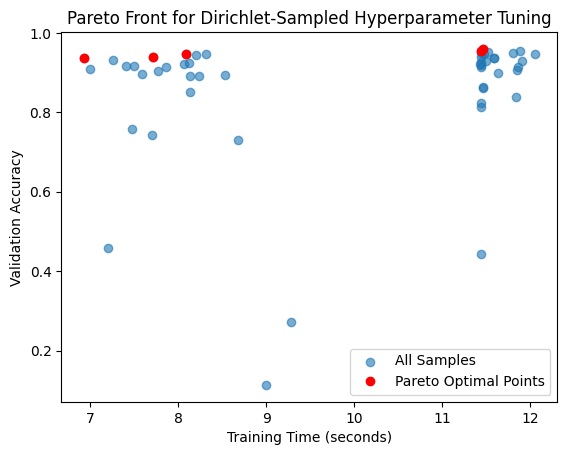

In [ ]:
(X_train, y_train), (X_test, y_test) = load_data()

# Generate hyperparameter configurations
dirichlet_params = dirichlet_sampling()

# Evaluate the configurations
performance_results_dirichlet = evaluate_hyperparameters(dirichlet_params, X_train, y_train, X_test, y_test)

animate_pareto(performance_results_dirichlet)

Grid search is an exhaustive algorithm that spans all the combinations, to find the best points in the sampel set.

Cons- SUper slow, computanially intensive. grid search tries every single combination of hyperparameter values within the ranges you specify, trains a model for each combination, and then picks the combination that gives the best results.

In [ ]:
# Generate hyperparameters using Grid Search
def grid_search():
    grid_learning_rates = [0.001, 0.005, 0.01]
    grid_dropout_rates = [0.1, 0.3, 0.5]
    grid_hidden_layer_sizes = [10, 50, 100]
    return list(product(grid_learning_rates, grid_dropout_rates, grid_hidden_layer_sizes))



Random search is a method for finding the best settings (hyperparameters) for a machine learning model, but instead of trying every possible combination like grid search, it picks combinations randomly.

In [ ]:
# Generate hyperparameters using Random Search
def random_search():
    random_learning_rates = np.random.uniform(0.001, 0.01, 10)
    random_dropout_rates = np.random.uniform(0.0, 0.5, 10)
    random_hidden_layer_sizes = np.random.randint(1, 100, 10)
    return list(zip(random_learning_rates, random_dropout_rates, random_hidden_layer_sizes))

In [ ]:
# Plot 3D hyperparameter configurations
def plot_3d_hyperparameters(results_by_method, methods):
    fig_3d = plt.figure()
    ax_3d = fig_3d.add_subplot(111, projection='3d')
    for i, results in enumerate(results_by_method):
        lrs = [result[2] for result in results]
        drs = [result[3] for result in results]
        hls = [result[4] for result in results]
        ax_3d.scatter(lrs, drs, hls, label=f'{methods[i]}', marker='o')
    ax_3d.set_xlabel('Learning Rate')
    ax_3d.set_ylabel('Dropout Rate')
    ax_3d.set_zlabel('Hidden Layer Size')
    plt.title('3D Plot of Hyperparameter Configurations')
    plt.legend()
    plt.show()

In [ ]:
# Generate hyper params config
grid_params = grid_search()
random_params = random_search()

performance_results_grid = evaluate_hyperparameters(grid_params, X_train, y_train, X_test, y_test)
performance_results_random = evaluate_hyperparameters(random_params, X_train, y_train, X_test, y_test)

# Plot results
methods = ['Dirichlet', 'Grid Search', 'Random Search']
all_results = [performance_results_dirichlet, performance_results_grid, performance_results_random]

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


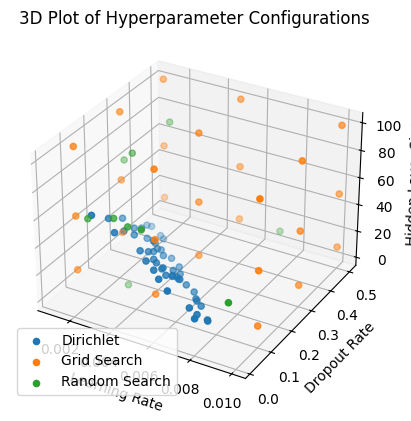

In [ ]:
plot_3d_hyperparameters(all_results, methods)

In [ ]:
# Display best hyperparameter samples
print("Best Hyperparameter Samples by Method:")
for method, results in zip(methods, all_results):
  best_sample = max(results, key=lambda x: x[0])
  acc, time_taken, lr, dr, hs = best_sample
  print(f"{method} -> Accuracy: {acc:.4f}, Time: {time_taken:.2f}s, LR: {lr:.5f}, Dropout: {dr:.2f}, Hidden Size: {hs}")

Best Hyperparameter Samples by Method:
Dirichlet -> Accuracy: 0.9595, Time: 11.46s, LR: 0.00333, Dropout: 0.07, Hidden Size: 52
Grid Search -> Accuracy: 0.9607, Time: 7.93s, LR: 0.00500, Dropout: 0.10, Hidden Size: 100
Random Search -> Accuracy: 0.9620, Time: 11.46s, LR: 0.00236, Dropout: 0.04, Hidden Size: 62
